# Setup

## Load Modules

In [1]:
%matplotlib notebook

# Standard library
import os.path, logging, collections

# External modules
from neuron import h
import numpy as np
import matplotlib.pyplot as plt

# Our modules
from bgcellmodels.common import analysis, logutils
from bgcellmodels.morphology import morph_ni
from bgcellmodels.extensions.pynn import axon_models
from bgcellmodels.models.axon import foust2011 as foust

# Hoc standard libray
h.load_file('stdlib.hoc')
h.load_file('stdrun.hoc')

## Settings

In [2]:
# Global variables

logger = logging.getLogger('STN_MORPH')
logger.setLevel(logging.DEBUG)
logging.basicConfig(format=logutils.DEFAULT_FORMAT)

# Make Axon

In [3]:
# Load streamline
streamlines_path = '/home/luye/Documents/mri_data/Waxholm_rat_brain_atlas/WHS_DTI_v1_ALS/S56280_ROI-STN-bilateral.tck'
axon_coords = morph_ni.load_streamlines(streamlines_path, max_num=1, min_length=2.0)[0]

# Cell parameters
cell_params = dict(axon_models.AxonRelayType.default_parameters)
cell_params['axon_class'] = foust.AxonFoust2011
cell_params['streamline_coordinates_mm'] = axon_coords
cell_params['transform'] = np.eye(4)
cell_params['termination_method'] = np.array('terminal_sequence')
cell_params['with_extracellular'] = False

# instantiate cell
model = axon_models.AxonRelayType.model(**cell_params)
icell = model.icell

DEBUG:AxonBuilder@axon_base.py:562: Estimated number of sections to build axon  of length 4.26035881042 mm: 42.2
DEBUG:AxonBuilder@axon_base.py:657: Created 238 axonal segments (40 sections)


# Protocol

In [36]:
# Inject spikes into axon

# Stimulation settings
rate = 200.0
num_spikes = 30
noise = 0.0

# One spike generator for background spikes
stim = h.NetStim()
stim.interval = (rate ** -1) * 1e3
stim.number = num_spikes
stim.noise = noise
stim.start = 100.0

syn = model.excitatory # Exp2Syn
syn.tau1 = 0.1
syn.tau2 = 0.2
syn.e = 0.0

nc = h.NetCon(stim, syn)
nc.delay = 1.0
nc.weight[0] = 1.0

# Recordings

In [37]:
# Define traces
rec_secs = {
    'ax_init': model.icell.ordered[0],
    'ax_term': model.icell.ordered[-1],
    'ax_mid': model.icell.node[int(len(model.icell.node) / 2)],
    'syn': syn,
}

trace_specs = {
    'V_init': {'var':'v', 'sec':'ax_init', 'loc':0.5},
    'V_term': {'var':'v', 'sec':'ax_term', 'loc':0.5},
    'V_mid':  {'var':'v', 'sec':'ax_mid', 'loc':0.5},
    # Synapse variables
    'isyn': {'pointp':'syn', 'var':'i'},
}

# Record
rec_dt = 0.05
vec_dict, markers = analysis.recordTraces(rec_secs, trace_specs, rec_dt)

# Modifications

Modifications to axon model.

In [53]:
for sec in icell.node:
    # AIS node parameters
    sec.g_pas_Foust = 0.000033
#     sec.g_NaF_Foust = 0.4
#     sec.g_Kv_Foust = 0.002
#     sec.g_Kd_Foust = 0.015
    # internode parameters
#     sec.g_pas_Foust = 0.02
    sec.g_NaF_Foust = 0.28
    sec.g_Kv_Foust = 0.0005
    sec.g_Kd_Foust = 0.0072

# Simulate

In [54]:
h.dt = 0.025
h.tstop = 1000.0

h.celsius = 35.0
h.v_init = -68.0

h.init()
h.run()

0.0

<IPython.core.display.Javascript object>


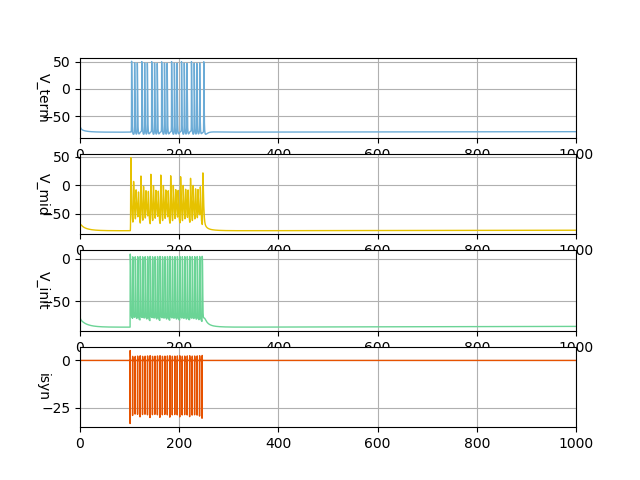

In [55]:
figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True)